In [78]:
%matplotlib notebook

import numpy as np
import pandas as pd
import math as mt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import re

In [240]:
def read_file_basic_preprocess():
    train_df = pd.read_csv("train.csv", index_col='PassengerId')
    test_df = pd.read_csv("test.csv", index_col='PassengerId')
    
    train_df['Title'] = train_df['Name'].str.extract(r'([A-Za-z]+\.)', expand=False)
    test_df['Title'] = test_df['Name'].str.extract(r'([A-Za-z]+\.)', expand=False)
    
    train_df['Title'] =  train_df['Title'].replace({'Mlle.': 'Miss.', 'Mme.': 'Miss.',
                                                    'Sir.': 'Mr.', 'Capt.': 'Others',
                                                    'Col.': 'Others', 'Countess.': 'Others',
                                                    'Don.': 'Others', 'Dr.': 'Others',
                                                    'Jonkheer.': 'Others', 'Lady.': 'Others',
                                                    'Major.': 'Others', 'Ms.': 'Others',
                                                    'Rev.': 'Others', 'Dona.': 'Others'
                                                   })
    test_df['Title'] =  test_df['Title'].replace({'Mlle.': 'Miss.', 'Mme.': 'Miss.',
                                                    'Sir.': 'Mr.', 'Capt.': 'Others',
                                                    'Col.': 'Others', 'Countess.': 'Others',
                                                    'Don.': 'Others', 'Dr.': 'Others',
                                                    'Jonkheer.': 'Others', 'Lady.': 'Others',
                                                    'Major.': 'Others', 'Ms.': 'Others',
                                                    'Rev.': 'Others', 'Dona.': 'Others'
                                                   })
    
    train_df.drop(['Name', 'Ticket'], axis=1, inplace=True)
    test_df.drop(['Name', 'Ticket'], axis=1, inplace=True)
#     idx = train_df[train_df['Age'].isnull()].index.tolist()
#     str1 = train_df['Age'].astype(str)
#     print(str1[~((str1.str.split('.', n=1).str[1].isnull()) | (str1.str.split('.', n=1).str[1]=='0'))])
    
#     X_train = train_df.drop('Survived', axis=1)
#     y_train = train_df['Survived']
#     X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    X_train = train_df
    
    X_train['Cabin'] = X_train['Cabin'].apply(lambda x: 1 if type(x)== str else 0)
    test_df['Cabin'] = test_df['Cabin'].apply(lambda x: 1 if type(x)== str else 0)
    
    train_embarked_col_most_freq = X_train['Embarked'].value_counts().index[0]
    X_train['Embarked'].fillna(train_embarked_col_most_freq, inplace=True)
    test_df['Embarked'].fillna(train_embarked_col_most_freq, inplace=True) 
    
    train_lgroup_age_median = (X_train.groupby(['Pclass', 'Sex','Embarked'])['Age']
                                      .apply(lambda x: x.median()))
    train_sgroup_age_median = (X_train.groupby(['Pclass', 'Sex'])['Age']
                                      .apply(lambda x: x.median()))
    X_train['Age'] = (X_train.groupby(['Pclass', 'Sex','Embarked'])['Age']
                             .transform(lambda x: x.fillna(train_lgroup_age_median[x.name])))
    test_df['Age'] = (test_df.groupby(['Pclass', 'Sex', 'Embarked'])['Age']
                             .transform(lambda x: x.fillna(train_lgroup_age_median[x.name])
                                        if x.name in set(train_lgroup_age_median.index.values)
                                        else x.fillna(train_sgroup_age_median[x.name])))
    
    train_group_fare_median = (X_train.groupby('Pclass')['Fare']
                                      .apply(lambda x: x.median()))
    test_df['Fare'] = (test_df.groupby('Pclass')['Fare']
                              .transform(lambda x: x.fillna(train_group_fare_median[x.name])))    

    X_train['Relatives'] = X_train['SibSp'] + X_train['Parch']
    X_train.drop(['SibSp', 'Parch'], axis=1, inplace=True) 
    test_df['Relatives'] = test_df['SibSp'] + test_df['Parch']
    test_df.drop(['SibSp', 'Parch'], axis=1, inplace=True)
    
    X_train['Alone'] = X_train['Relatives'].transform(lambda x: 1 if x==0 else 0)
    test_df['Alone'] = test_df['Relatives'].transform(lambda x: 1 if x==0 else 0)
    
    return X_train, test_df 

In [201]:
def handle_categorical_data(X_train, X_test):
    X_train_no_recs = len(X_train.index)
#     X_test_no_recs = len(X_test.index)
    
    X_temp = pd.concat([X_train, X_test])
    X_temp = pd.get_dummies(X_temp)
    
    X_train = X_temp.iloc[:X_train_no_recs,:]
#     X_records = X_train_no_recs+X_test_no_recs
#     X_test = X_temp.iloc[X_train_no_recs:X_records,:]
    X_test = X_temp.iloc[X_train_no_recs:,:]
    
    return X_train, X_test

In [199]:
def outliers_upd_median(col):
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    iqr = q3 - q1
    outliers_idx = ((col < (q1 - (1.5*iqr)))
                    | (col > (q3 + (1.5*iqr))))
    col[outliers_idx] = np.median(col[~outliers_idx])
    col[outliers_idx] = col[outliers_idx].round(4)
#     temp_col = StandardScaler().fit_transform(col.values.reshape(-1,1))
#     temp_col = temp_col.ravel()
#     outliers_idx  = ((temp_col < -3.0) | (temp_col > 3.0))    
#     col[outliers_idx] = np.median(col[~outliers_idx])
    return col

In [159]:
def get_bins(col, no_bins):
    bins = np.zeros((no_bins+1,))
    age_min = col.min(0)
    age_max = col.max(0)
    interval_size = (age_max - age_min)/ no_bins
    bins[0] = age_min
    for i in range(1, no_bins):
        bins[i] = bins[i-1] + interval_size
    bins[0] = -np.inf
    bins[no_bins] = np.inf
    return bins

In [241]:
if __name__ == '__main__':
    X_train, X_test = read_file_basic_preprocess()
    
    X_train_temp = X_train.copy()
    
    X_train['Fare'] = X_train.groupby('Pclass')['Fare'].transform(outliers_upd_median)
    
    bins = get_bins(X_train['Fare'], 5)
    X_train['Fare'] = pd.cut(X_train['Fare'], bins, 
                             labels=['vLow', 'Low', 'Medium', 'High', 'vHigh'])
    X_test['Fare'] = pd.cut(X_test['Fare'], bins,
                            labels=['vLow', 'Low', 'Medium', 'High', 'vHigh'])
    
    bins = get_bins(X_train['Age'], 8)
    X_train['Age'] = pd.cut(X_train['Age'], 8, 
                            labels=[str(i)+'-'+str(i+10) for i in range(0,80,10)])
    X_test['Age'] = pd.cut(X_test['Age'], 8, 
                           labels=[str(i)+'-'+str(i+10) for i in range(0,80,10)])
    
    categ_cols = list(X_train.select_dtypes(include=['object','category']).columns)
    X_train_categ, X_test_categ = handle_categorical_data(X_train[categ_cols], X_test[categ_cols])
    X_train[X_train_categ.columns] = X_train_categ
    X_test[X_test_categ.columns] = X_test_categ
    
    X_train.drop(categ_cols, axis=1, inplace=True)
    X_test.drop(categ_cols, axis=1, inplace=True)
#     X_train.drop(['Age', 'Fare'], axis=1, inplace=True)
#     X_test.drop(['Age', 'Fare'], axis=1, inplace=True)
    
    y_train = X_train['Survived']
    X_train.drop('Survived', axis=1, inplace=True)

#     cols_scale = ['Age', 'SibSp', 'Parch']
#     ss = StandardScaler()
#     X_train_temp[cols_scale] = ss.fit_transform(X_train_temp[cols_scale])
#     rows_with_outliers = ((X_train_temp[cols_scale] > 3.0) 
#                           | (X_train_temp[cols_scale] < -3.0)).any(axis=1)
#     X_train = X_train[~rows_with_outliers]
#     y_train = y_train[~rows_with_outliers]
#     X_test[cols_scale] = ss.transform(X_test[cols_scale])
#     test_df[cols_scale] = ss.transform(test_df[cols_scale])

    X_train.to_csv('X_train.csv')
    y_train.to_csv('y_train.csv')
    X_test.to_csv('Unseen_test.csv')

In [242]:
# X_train[[cols for cols in X_train.columns if ((cols.find('Title')!=-1))]].head()# | (cols.find('Age')!=-1))]].head()
# np.unique(X_train['Title'], return_counts=True)
X_train_temp.describe()

,Survived,Pclass,Age,Fare,Cabin,Relatives,Alone
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.132346,32.204208,0.228956,0.904602,0.602694
std,0.486592,0.836071,13.365516,49.693429,0.420397,1.613459,0.489615
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,21.000000,7.910400,0.000000,0.000000,0.000000
50%,0.000000,3.000000,27.000000,14.454200,0.000000,0.000000,1.000000
75%,1.000000,3.000000,36.000000,31.000000,0.000000,1.000000,1.000000
max,1.000000,3.000000,80.000000,512.329200,1.000000,10.000000,1.000000


In [166]:
X_test.head()

,Pclass,Cabin,Relatives,Alone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master.,...,Fare1_High,Fare1_vHigh,Age1_0-10,Age1_10-20,Age1_20-30,Age1_30-40,Age1_40-50,Age1_50-60,Age1_60-70,Age1_70-80
PassengerId,,,,,,,,,,,,,,,,,,,,,
892,3,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
893,3,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
894,2,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
895,3,0,0,1,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
896,3,0,2,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [211]:
X_train_temp['age_intervals'] = pd.cut(X_train_temp['Age'], 5)
X_train_temp[['age_intervals','Survived']].groupby('age_intervals').apply(np.mean).sort_values(by='Survived', ascending=False)

,Survived
age_intervals,
"(0.34, 16.336]",0.551402
"(48.168, 64.084]",0.434783
"(32.252, 48.168]",0.412844
"(16.336, 32.252]",0.333333
"(64.084, 80.0]",0.090909


In [226]:
X_train_temp['age_intervals'] = pd.cut(X_train_temp['Age'], 8)#, labels=['Age_'+str(i)+'-'+str(i+10) for i in range(0,80,10)])
X_train_temp[['age_intervals','Survived']].groupby('age_intervals').apply(np.mean)#.sort_values(by='Survived', ascending=False)

,Survived
age_intervals,
"(0.34, 10.368]",0.593750
"(10.368, 20.315]",0.462069
"(20.315, 30.263]",0.285303
"(30.263, 40.21]",0.464706
"(40.21, 50.158]",0.366337
"(50.158, 60.105]",0.404762
"(60.105, 70.052]",0.235294
"(70.052, 80.0]",0.200000


In [233]:
X_train_temp['fare_intervals'] = pd.cut(X_train_temp['Fare'], 8)
X_train_temp[['fare_intervals','Survived']].groupby('fare_intervals').apply(lambda x: x.mean())#.sort_values(by='fare_intervals', ascending=True)

fare_intervals                    
(-0.512, 64.041]    Survived          0.337646
(64.041, 128.082]   Survived          0.662500
(128.082, 192.123]  Survived          0.777778
(192.123, 256.165]  Survived          0.636364
(256.165, 320.206]  Survived          0.666667
(320.206, 384.247]  fare_intervals         NaN
                    Survived               NaN
(384.247, 448.288]  fare_intervals         NaN
                    Survived               NaN
(448.288, 512.329]  Survived          1.000000
dtype: float64

In [124]:
X_train.dtypes

Survived             int64
Pclass               int64
Age                float64
Fare               float64
Relatives            int64
Alone                int64
Sex_female           uint8
Sex_male             uint8
Embarked_C           uint8
Embarked_Q           uint8
Embarked_S           uint8
fare_intervals    category
age_intervals     category
dtype: object

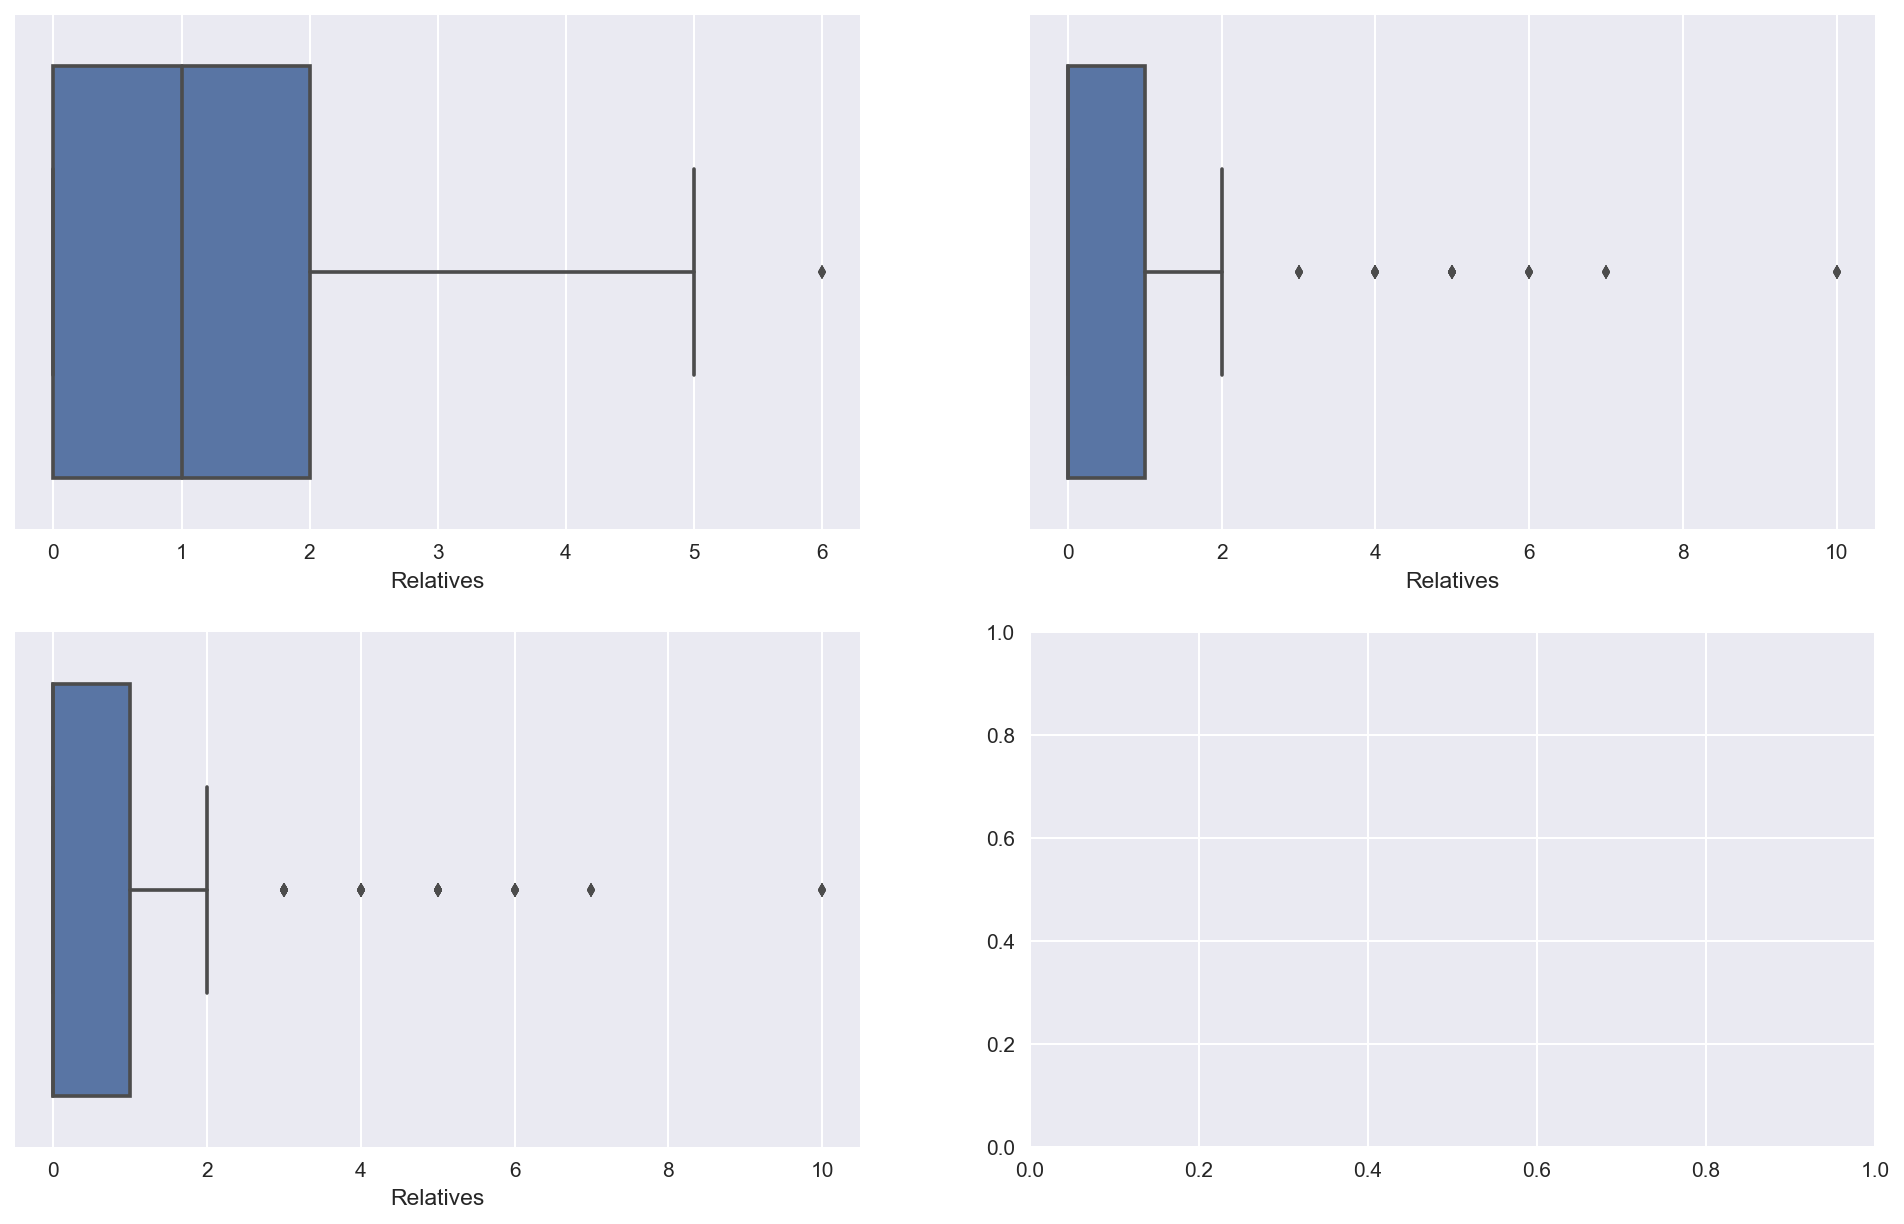

In [202]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.rcParams['figure.dpi']=150
fig, ax = plt.subplots(2, 2, figsize=(16,10))
sns.boxplot(X_train[y_train==1]['Relatives'], ax=ax[0][0])
sns.boxplot(X_train[y_train==0]['Relatives'], ax=ax[0][1])
sns.boxplot(X_train['Relatives'], ax=ax[1][0])
# sns.boxplot(X_train[y_train==1]['Parch'] + X_train[y_train==1]['SibSp'], ax=ax[0][0])
# sns.boxplot(X_train[y_train==0]['Parch'] + X_train[y_train==0]['SibSp'], ax=ax[0][1])
# sns.boxplot(X_train['Parch'] + X_train['SibSp'], ax=ax[1][0])

In [208]:
X_train_temp.head()

,Pclass,Cabin,Relatives,Alone,Sex_female,Sex_male,Age_0-10,Age_10-20,Age_20-30,Age_30-40,...,Fare_High,Fare_vHigh,Embarked_C,Embarked_Q,Embarked_S,Title_Master.,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Others
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,3,0,1,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
2,1,1,1,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
3,3,0,0,1,1,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
4,1,1,1,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
5,3,0,0,1,0,1,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0


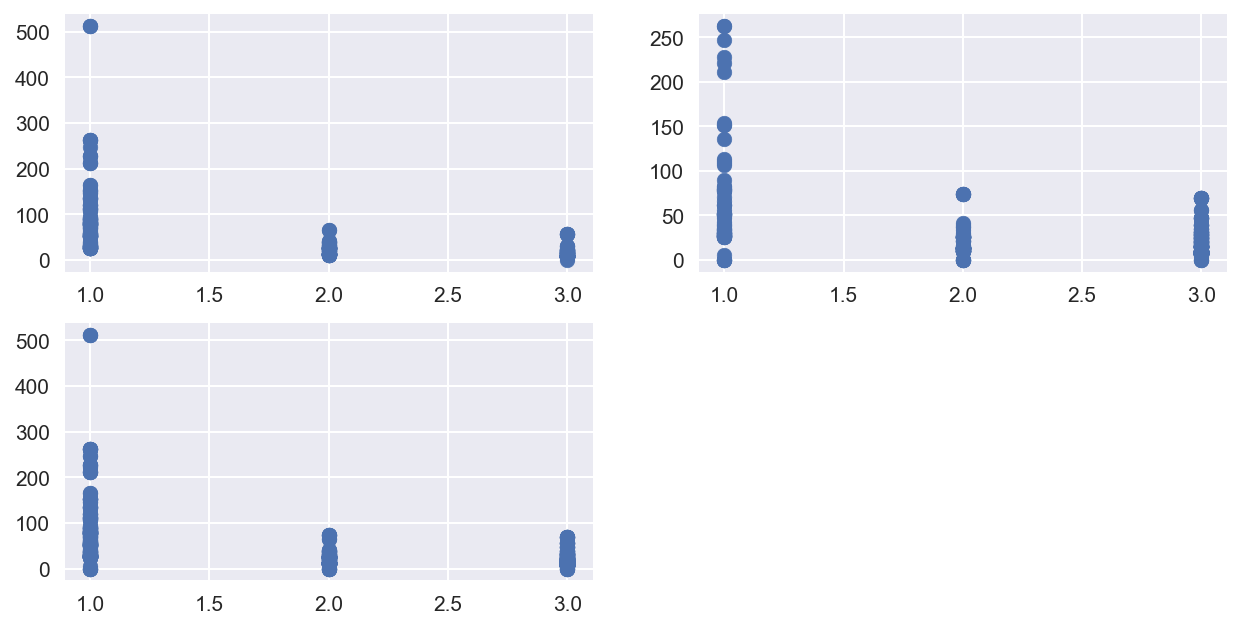

In [210]:
plt.figure(2, figsize=(10,5))
plt.subplot(221)
plt.scatter(X_train_temp[y_train==1]['Pclass'], X_train_temp[y_train==1]['Fare'])
plt.subplot(222)
plt.scatter(X_train_temp[y_train==0]['Pclass'], X_train_temp[y_train==0]['Fare'])
plt.subplot(223)
plt.scatter(X_train_temp['Pclass'], X_train_temp['Fare'])

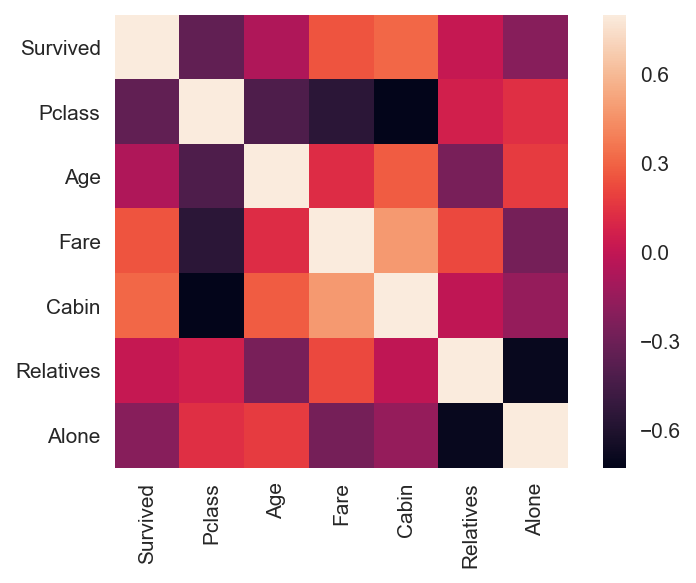

In [236]:
sns.heatmap(X_train_temp.corr(), vmax=.8, square=True)

In [302]:
np.unique(X_train['SibSp'], return_counts=True)

(array([0, 1, 2, 3, 4, 5, 8], dtype=int64),
 array([608, 209,  28,  16,  18,   5,   7], dtype=int64))

In [303]:
np.unique(X_train['Parch'], return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int64),
 array([678, 118,  80,   5,   4,   5,   1], dtype=int64))

In [345]:
q1_fare = X_train_temp[X_train_temp['Pclass']==3]['Fare'].quantile(0.25)
q3_fare = X_train_temp[X_train_temp['Pclass']==3]['Fare'].quantile(0.75)
iqr_fare = q3_fare - q1_fare
fare_is_outlier = ((X_train_temp[X_train_temp['Pclass']==3]['Fare'] < q1_fare-(1.5*iqr_fare))
                 | (X_train_temp[X_train_temp['Pclass']==3]['Fare'] > q3_fare+(1.5*iqr_fare)))
print(X_train_temp.loc[fare_is_outlier[fare_is_outlier==True].index,'Fare'].values)
# len(fare_outliers_indices)

[21.075  16.7    18.     21.075  18.     15.5    21.6792 17.8    15.2458
 14.4542 15.85   20.575  24.15   14.4542 14.4583 22.3583 14.5    15.2458
 15.85   14.5    16.1    20.525  25.4667  0.     22.025  15.5    15.5
 15.85   18.7875 25.4667 14.4542 15.5    16.1    20.2125 15.2458  0.
 20.25   23.25    0.     20.525  23.25   18.     16.1    15.9    17.8
 14.4542 15.5    21.075  15.7417 16.7    15.85   25.4667 24.15   14.4
 20.2125 16.1    19.2583 19.9667 19.2583 25.4667 15.9    19.9667 14.4583
 15.1    22.525  24.15   22.3583 14.5    20.525  17.4    24.15   21.075
 14.5    14.4583 24.15    0.     15.55   15.5    14.4    16.1    14.4542
 15.7417 16.1    16.1    19.2583 15.5    14.4542 15.2458 15.5    18.7875
 16.1    16.1    20.25   14.5    24.15   23.45   20.575  24.15   24.15
 14.4542 15.2458 19.2583 14.1083 23.45  ]


In [108]:
multi_pass_tick = train_df['Ticket'].value_counts()>1
multi_pass_tick[multi_pass_ticket==True].index

Index(['CA. 2343', '347082', '1601', 'CA 2144', '347088', '3101295',
       'S.O.C. 14879', '382652', '4133', 'PC 17757',
       ...
       '2659', 'PC 17611', '2908', '13507', '2668', '250644', '11751',
       'PC 17604', '26360', 'WE/P 5735'],
      dtype='object', length=134)

In [91]:
train_df.nunique()

Survived      2
Pclass        3
Sex           2
Age          89
SibSp         7
Parch         7
Ticket      681
Fare        248
Embarked      3
dtype: int64